# FICO HELOC Modeling
https://community.fico.com/s/explainable-machine-learning-challenge

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

file_path = os.path.dirname(os.path.realpath('fico_heloc.iypynb'))
os.chdir(file_path) # Change directory

Here are some customized functions for model training and reporting

In [2]:
#%% User-defined functions

# Print summary for out-of-sample model perforamce
def model_summary(y_test, tc_predict, dtc_cv_score):
    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_test, dtc_predict))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, dtc_predict))
    print('\n')
    print("=== All AUC Scores ===")
    print(dtc_cv_score)
    print('\n')
    print("=== Mean AUC Score ===")
    print("Mean AUC Score - Random Forest: ", dtc_cv_score.mean())

# Search for best depth parameter for decision tree model
def tree_depth_search (X_train, X_test, y_train, y_test, criterion, depth_range):
    dt2 = pd.DataFrame()
    for i in depth_range:
        
        clf = tree.DecisionTreeClassifier(criterion=criterion, max_depth=i, random_state=66)
        clf = clf.fit(X_train,y_train)
        out_sample_pred = clf.predict(X_test)
        in_sample_pred = clf.predict(X_train)
        in_acc = sk.metrics.accuracy_score(y_train, in_sample_pred)
        out_acc = sk.metrics.accuracy_score(y_test, out_sample_pred)
        in_conf = sk.metrics.confusion_matrix(y_train, in_sample_pred)
        out_conf = sk.metrics.confusion_matrix(y_test, out_sample_pred)
        tpr_in = in_conf[1][1]/(in_conf[1][0]+in_conf[1][1])
        tpr_out = out_conf[1][1]/(out_conf[1][0]+out_conf[1][1])
        fpr_in = in_conf[0][1]/(in_conf[0][0]+in_conf[0][1])
        fpr_out = out_conf[0][1]/(out_conf[0][0]+out_conf[0][1])
        
        dt1 = pd.DataFrame({'Depth': [i, i], 'Sample': ['In-Sample', 'Out-Sample'], 'Accuracy': [in_acc, out_acc],
                            "TPR": [tpr_in,tpr_out], "FPR": [fpr_in, fpr_out]})
        dt2 = pd.concat([dt2, dt1])
   
    return dt2

## Data Import and Cleaning
We are going to skip the detailed data cleaning steps here and simply exclude some missing value.

In [3]:
#%% Import and prepare data

df = pd.read_csv(file_path + '/Data/heloc_dataset_v1.csv')

# The target variable to predict is a binary variable called RiskPerformance. 
target_variable = 'RiskPerformance'
df[target_variable].drop_duplicates()
target_names = ['Good', 'Bad']

# Create standardized target varibale column
df.loc[df[target_variable]==target_names[0],'Class'] = 0
df.loc[df[target_variable]==target_names[1],'Class'] = 1
df['Class'] = df['Class'].astype(int)
df.groupby('Class')['Class'].count() # Count of categorical variable

# Convert categorical variables to proper types
df.dtypes
var_category = [target_variable]  #Keep 'Class' as numerical since it only has two values
df[var_category] = df[var_category].astype('category')


In [4]:
#%% Data cleaning 

# Data cleaning and exclusion
## Special values according to data dictionary
df[df==-9].count() # -9 No Bureau Record or No Investigation
df = df[df['ExternalRiskEstimate']!=-9] #Exclude records 

dt1 = df[df==-8].count() # -8 No Usable/Valid Trades or Inquiries
dt1[dt1>0]
#!!! Need to figure out strategy
# MSinceOldestTradeOpen                  239
# MSinceMostRecentDelq                   176
# MSinceMostRecentInqexcl7days           476
# NetFractionRevolvingBurden             186
# NetFractionInstallBurden              3419
# NumRevolvingTradesWBalance             156
# NumInstallTradesWBalance               861
# NumBank2NatlTradesWHighUtilization     583
# PercentTradesWBalance                   18

df[df==-7].count() # -7 Condition not Met (e.g. No Inquiries, No Delinquencies)
#MSinceMostRecentDelq, MSinceMostRecentInqexcl7days
#!!! Should we use an artificially large number to relace -7 given the relationship constraint with the target variable

## MaxDelq2PublicRecLast12M	
df.groupby('MaxDelq2PublicRecLast12M')['MaxDelq2PublicRecLast12M'].count() 
# No adjustments needed - Values 0-7 are monotonically decreasing
# value      meaning                                                                       	
# 0	derogatory comment
# 1	120+ days delinquent
# 2	90 days delinquent
# 3	60 days delinquent
# 4	30 days delinquent
# 5, 6	unknown delinquency
# 7	current and never delinquent
# 8, 9	all other

## MaxDelqEver	
df.groupby('MaxDelqEver')['MaxDelqEver'].count() 
# No adjustments needed - Values 2-8 are monotonically decreasing
# value     meaning	
# 1	No such value
# 2	derogatory comment
# 3	120+ days delinquent
# 4	90 days delinquent
# 5	60 days delinquent
# 6	30 days delinquent
# 7	unknown delinquency
# 8	current and never delinquent
# 9	all other

MaxDelqEver
2     738
3     311
4     319
5     968
6    2867
7     132
8    4526
Name: MaxDelqEver, dtype: int64

Based on the correlation matrix, some of the top features are 
* ExternalRiskEstimate: Consolidated version of risk markers (-)
* NetFractionRevolvingBurden: Net Fraction Revolving Burden. This is revolving balance divided by credit limit (+)
* PercentTradesWBalance: Percent Trades with Balance (+/-)
* PercentTradesNeverDelq: Percent Trades Never Delinquent (-)
* AverageMInFile: Average Months in File (-)
* MaxDelq2PublicRecLast12M: Max Delq/Public Records Last 12 Months.  (-)
* MaxDelqEver: Max Delinquency Ever.  (-)
* MSinceOldestTradeOpen: Months Since Oldest Trade Open (-)
* NumTrades60Ever2DerogPubRec: Number Trades 60+ Ever (+)

Note: we include the monotonicity constraints given by FICO in parenthesis above, and they are consistent with the correlations with the target variable

In [5]:
#%% Data exploration

df = df[df['ExternalRiskEstimate']!=-9] #Exclude records 

# Feature variables
feature_variables = list(df.columns)
feature_variables.remove(target_variable)
feature_variables.remove('Class')

# Data summary 
## Descriptive stats for numerical variables
df_summary = df[['Class'] + feature_variables].describe()
## Descriptive stats for categorical variables
df_summary2 = df.groupby(var_category)[var_category].count()

## Correlations for numerical variables
df_corr = df[['Class'] + feature_variables].corr() #Point Biserial Correlation btw Class and feature variables

## Top correlated feature variables
feature_corr = pd.DataFrame({'corr': df_corr['Class'], 'abs_corr': abs(df_corr['Class'])})
feature_corr.sort_values(by = 'abs_corr', ascending=False, inplace=True)
feature_corr.head(10) 

## Output to excel
# with pd.ExcelWriter('output_data_summary.xlsx') as writer:  
#     df_summary.to_excel(writer, sheet_name='Summary_Numeric')
#     df_summary2.to_excel(writer, sheet_name='Summary_Category')
#     df_corr.to_excel(writer, sheet_name='Corr1')
#     feature_corr.to_excel(writer, sheet_name='Corr2')

## Other correlation methods
# from scipy import stats
# stats.f_oneway(df.loc[df[target_variable]==target_names[0], feature_variables[0]],
#                df.loc[df[target_variable]==target_names[1], feature_variables[0]]) #ANOVA when Class has two or more values
# stats.pearsonr(df[feature_variables[0]], df[feature_variables[1]]) #Pearson’s Correlation
# stats. spearmanr(df[feature_variables[0]], df[feature_variables[1]]) #Spearman’s Correlation

,corr,abs_corr
Class,1.000000,1.000000
ExternalRiskEstimate,-0.460381,0.460381
NetFractionRevolvingBurden,0.330972,0.330972
PercentTradesWBalance,0.275933,0.275933
PercentTradesNeverDelq,-0.257591,0.257591
AverageMInFile,-0.246518,0.246518
MaxDelq2PublicRecLast12M,-0.236895,0.236895
MaxDelqEver,-0.216894,0.216894
MSinceOldestTradeOpen,-0.204427,0.204427
NumTrades60Ever2DerogPubRec,0.169181,0.169181


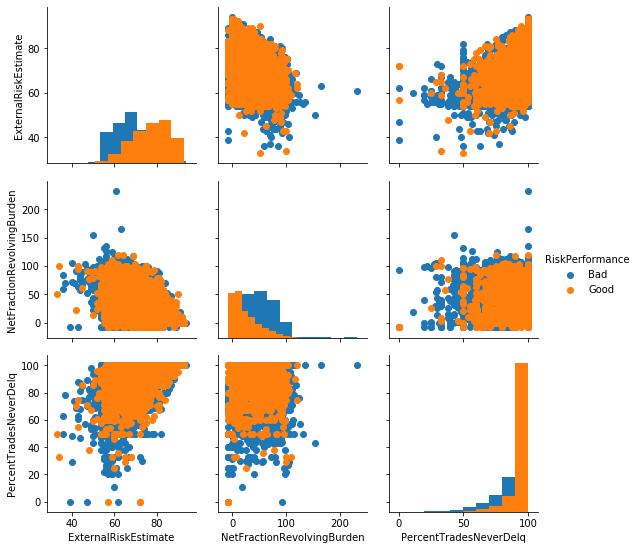

In [6]:
#%% Data visualization

# Box plot
#sns.boxplot(x="ExternalRiskEstimate", y=target_variable, data=df)


#Structure multi-plots
#col1 = "MaxDelq2PublicRecLast12M"
#var_x = "ExternalRiskEstimate"
#var_y = "PercentTradesNeverDelq"

#g = sns.FacetGrid(df, col=col1, col_wrap=3, height=3, hue=target_variable)
#g.map(plt.scatter, var_x, var_y,  alpha=.7)
#g.add_legend();


#Pairwise plot
vars1 = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'PercentTradesNeverDelq']

g = sns.PairGrid(df[vars1+[target_variable]], hue=target_variable)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

## Decision Tree Model

=== Confusion Matrix ===
[[1112  444]
 [ 500 1199]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1556
           1       0.73      0.71      0.72      1699

    accuracy                           0.71      3255
   macro avg       0.71      0.71      0.71      3255
weighted avg       0.71      0.71      0.71      3255



=== All AUC Scores ===
[0.77993066 0.74183697 0.77607779 0.7466876  0.76100458 0.80307564
 0.76440661 0.70044179 0.77018229 0.79715932]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7640803255924954


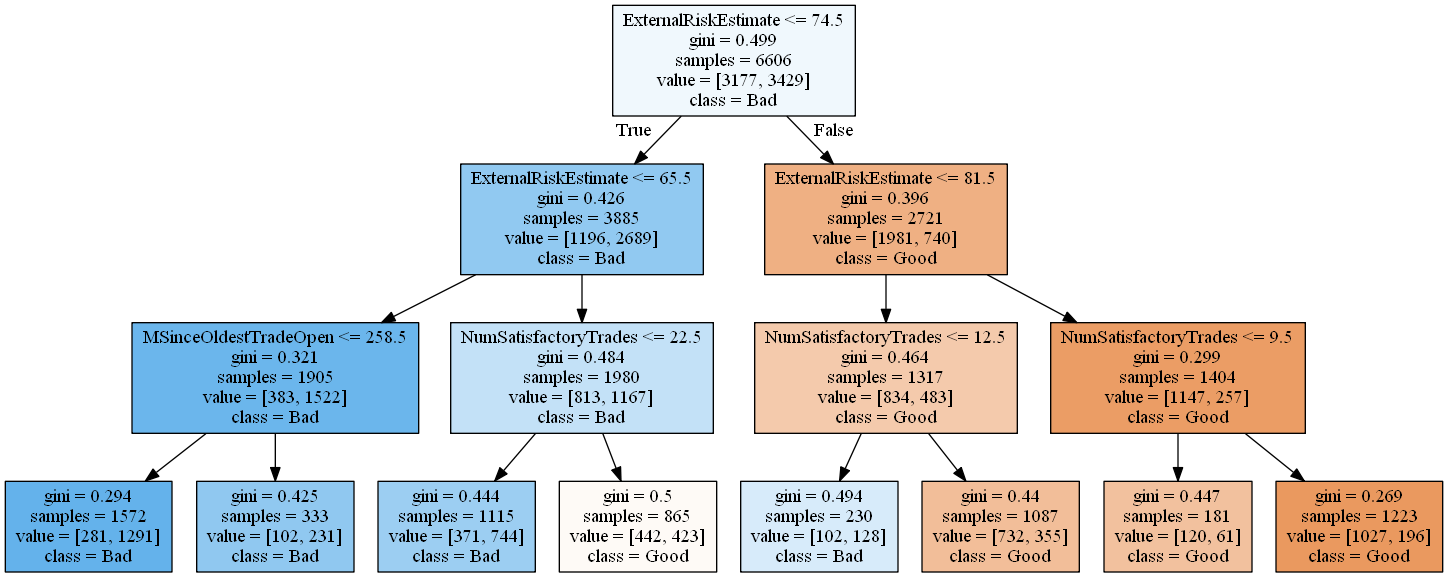

In [7]:
#%% Feature selections

#Define predcitors and target variable
X = df[feature_variables].copy() #Change default here if we need to drop some variables
y = df['Class'].copy()

# Implement train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

# Preliminary model fit
dtc = tree.DecisionTreeClassifier(max_depth=3)
dtc = dtc.fit(X_train, y_train)
dtc_predict = dtc.predict(X_test) # predictions
dtc_cv_score = cross_val_score(dtc, X, y, cv=10, scoring='roc_auc') #scores
model_summary(y_test, dtc_predict, dtc_cv_score) # Model summary

## Plot the tree
dot_data = tree.export_graphviz(dtc, feature_names=feature_variables, class_names=target_names, out_file=None, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
# graph.write_png("tree_model1.png")

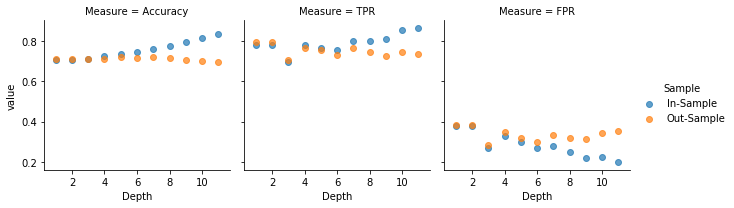

In [13]:
# Model optimization
dtc_depth = tree_depth_search(X_train, X_test, y_train, y_test, criterion='entropy', depth_range=range(1, 12))

## Plot the model measures
dt1 = pd.melt(dtc_depth, id_vars=['Depth', 'Sample'], var_name='Measure') #Reshape data

g = sns.FacetGrid(dt1, col='Measure', hue='Sample')
g.map(plt.scatter, "Depth", "value",  alpha=.7)
g.add_legend(title=None);

=== Confusion Matrix ===
[[1017  539]
 [ 393 1306]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.65      0.69      1556
           1       0.71      0.77      0.74      1699

    accuracy                           0.71      3255
   macro avg       0.71      0.71      0.71      3255
weighted avg       0.71      0.71      0.71      3255



=== All AUC Scores ===
[0.76675221 0.75216465 0.78474257 0.75669589 0.77972297 0.81135302
 0.76907591 0.71080243 0.7872742  0.79297493]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7711558779975239


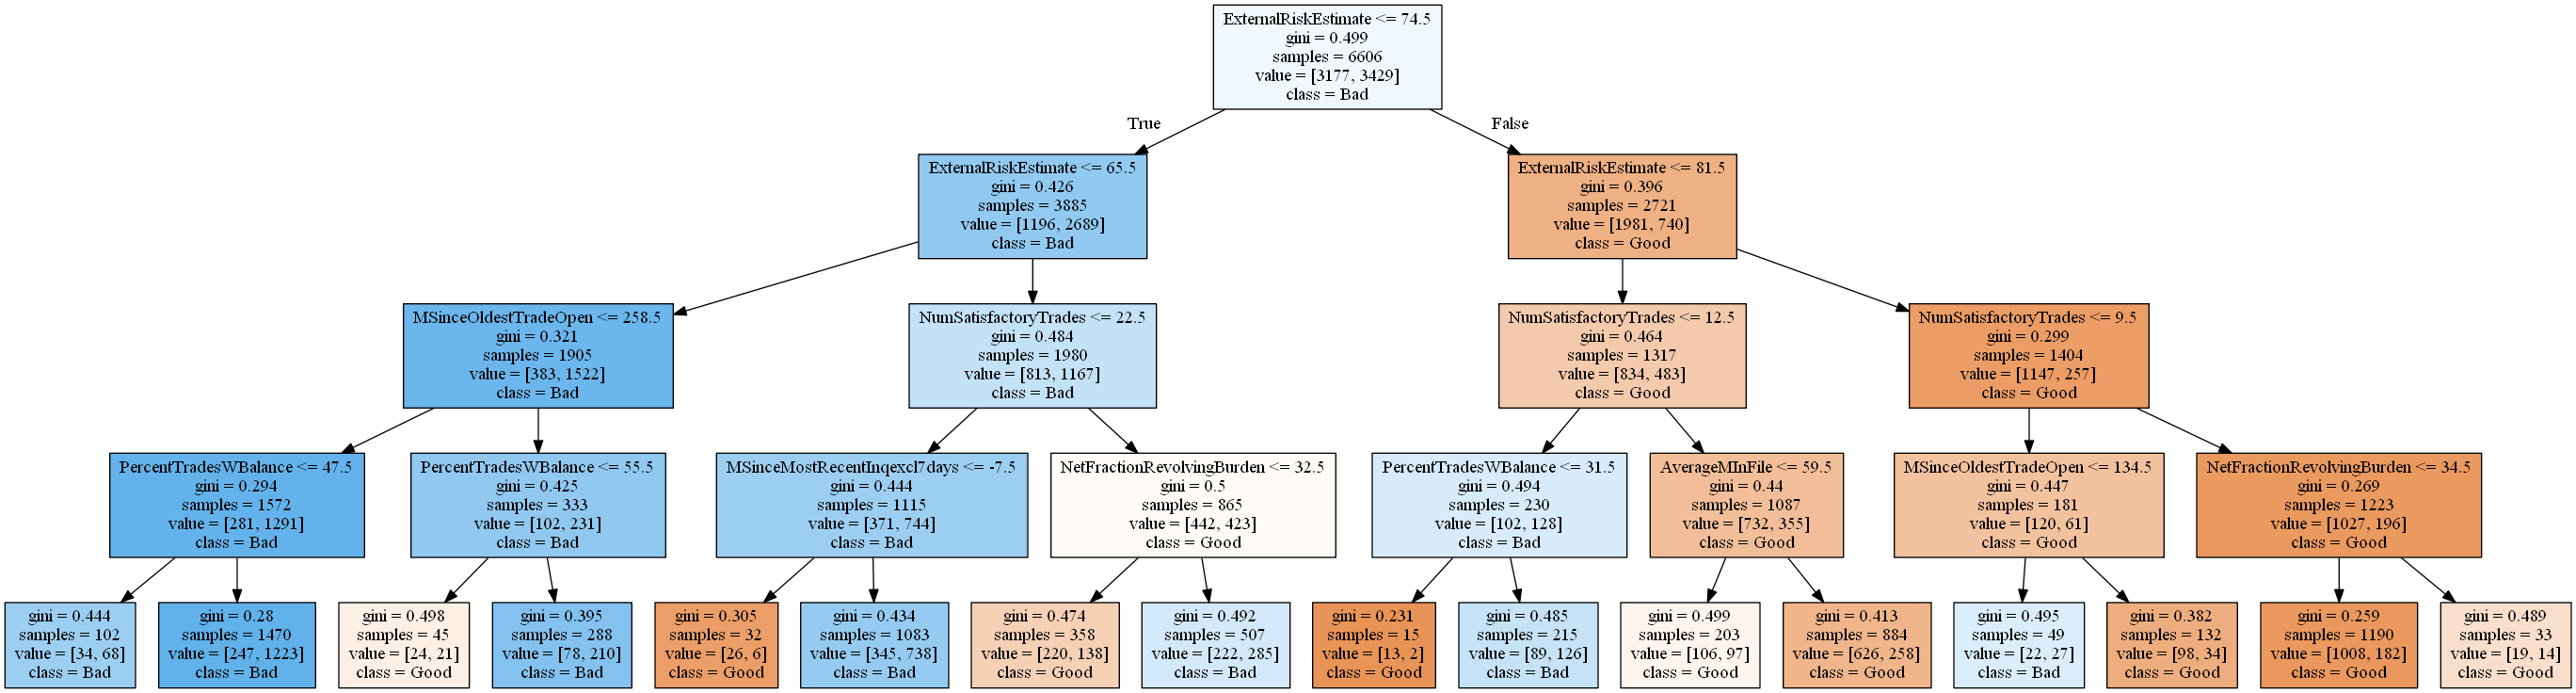

In [9]:
# Refit the model using tuned parameters
dtc = tree.DecisionTreeClassifier(max_depth=4)
dtc = dtc.fit(X_train, y_train)
dtc_predict = dtc.predict(X_test) # predictions
dtc_cv_score = cross_val_score(dtc, X, y, cv=10, scoring='roc_auc') #scores
model_summary(y_test, dtc_predict, dtc_cv_score) # Model summary

## Plot the tree
dot_data = tree.export_graphviz(dtc, feature_names=feature_variables, class_names=target_names, out_file=None, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
# graph.write_png("tree_model2.png")

### Notes on the Tree Model
* The highest correlated variable ExternalRiskEstimate (consolidated version of risk markers) appears in the first and second nodes and has the exhibits the correct relationship with the predicted variable (monotonically decreasing)
* Other variables generally exhibit expected behaviors. However, the PercentTradesWBalance variable doesn't appear to be supported by an underlying economic theory.
* Overall model performance is very similar with depth parameter at 4 to 6. A simpler tree with depth of 4 may be preferred in this case.

## Random Forest Model

In [10]:
# Preliminary model fit
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train) #fit
rfc_predict = rfc.predict(X_test) # predictions
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc') #scores
model_summary(y_test, rfc_predict, rfc_cv_score) # Model summary

=== Confusion Matrix ===
[[1017  539]
 [ 393 1306]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.65      0.69      1556
           1       0.71      0.77      0.74      1699

    accuracy                           0.71      3255
   macro avg       0.71      0.71      0.71      3255
weighted avg       0.71      0.71      0.71      3255



=== All AUC Scores ===
[0.7943223  0.78960968 0.80088111 0.77326303 0.79820234 0.81729576
 0.80543295 0.73948584 0.82176086 0.82861328]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7968867162307091


In [11]:
# Model optimization
## Optimize select hyperparamaters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)] # number of trees in random forest
max_features = ['auto', 'sqrt'] # number of features at every split
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)] # max depth
max_depth.append(None)

## Create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

## Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, 
                                cv = 3, verbose=2, random_state=66, n_jobs = -1)
rfc_random.fit(X_train, y_train) # Fit the model
print(rfc_random.best_params_) # Print results

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.9min finished


{'n_estimators': 1366, 'max_features': 'auto', 'max_depth': 140}


=== Confusion Matrix ===
[[1017  539]
 [ 393 1306]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.65      0.69      1556
           1       0.71      0.77      0.74      1699

    accuracy                           0.71      3255
   macro avg       0.71      0.71      0.71      3255
weighted avg       0.71      0.71      0.71      3255



=== All AUC Scores ===
[0.79255599 0.79103149 0.80753063 0.77842892 0.80081723 0.81976847
 0.81223908 0.74232327 0.8193174  0.83385252]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7997865003151629


,Gini-importance
ExternalRiskEstimate,0.125181
MSinceOldestTradeOpen,0.069034
MSinceMostRecentTradeOpen,0.042086
AverageMInFile,0.078815
NumSatisfactoryTrades,0.051890


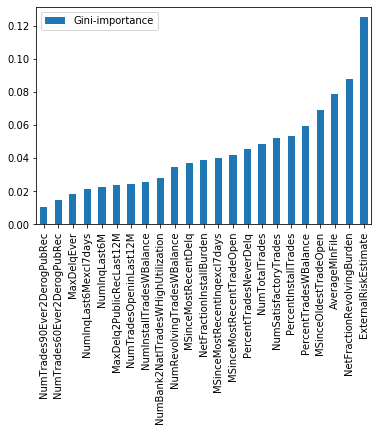

In [14]:
# Refit the model using tuned parameters
rfc = RandomForestClassifier(n_estimators=1366, max_depth=140, max_features='auto')
rfc.fit(X_train,y_train) #fit
rfc_predict = rfc.predict(X_test) # predictions
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc') #scores
model_summary(y_test, rfc_predict, rfc_cv_score) # Model summary


# Feature Importance
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90) #Plot
importances.head() # Print the feature ranking

## Notes on the Random Forest Model
* Need to further investigate the method for hyperparamater optimizations
* We don't see much improvement in terms of performance compared to a simple tree model
* The most important variables are generally consistent with those in the simple tree model